@author: spe

This example covers calculating the forces in a type-I, three-dimensional MOT
in a variety of different ways and comparing the various results.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import pylcp.tools
#plt.style.use('paper')

# %% Set up a coordinate system and laser parameters:
x = np.arange(-30, 30, 0.4)
v = np.arange(-30, 30, 0.4)

X, V = np.meshgrid(x, v)

# Define the three-vectors used in the calculation:
Rvec = [X, np.zeros(X.shape), np.zeros(X.shape)]
Vvec = [V, np.zeros(V.shape), np.zeros(V.shape)]

# Laser beams:
det = -4.0
alpha = 0.7
beta = 5.0
nb = 2.0

# Define the laser beams:
laserBeams = pylcp.laserBeams([{'kvec':np.array([1, 0, 0]), 'beta': beta, 'pol':-1, 'delta':det},
                               {'kvec':np.array([-1, 0, 0]), 'beta': beta, 'pol':-1, 'delta':det}])

# Actual linear gradient:
linGrad = lambda R: np.array([-alpha*R[0], np.zeros(R[1].shape),
                              np.zeros(R[2].shape)])

Let's start with $F=0\rightarrow F=1$ atom as a comparison case.

In [7]:
# Define the atomic Hamiltonian:
Hg, muq_g = pylcp.hamiltonians.singleF(F=0, muB=1)
He, muq_e = pylcp.hamiltonians.singleF(F=1, muB=1)

d_q = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

ham = pylcp.hamiltonian(Hg, He, muq_g, muq_e, d_q)
trap = pylcp.trap_rateeq(laserBeams, linGrad, ham, svd_eps=1e-10, include_mag_forces=False)
trap.generate_force_profile(Rvec, Vvec, name='Fx')
F = trap.profile['Fx'].F[0]

Let's consider a more complicated atom F=1 to F=2 atom and solve for the
force using the rate equations.

Text(0.5, 0, '$x$')

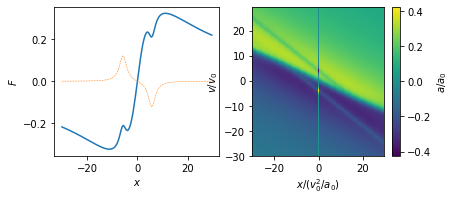

In [8]:
# Define the atomic Hamiltonian:
Hg, muq_g = pylcp.hamiltonians.singleF(F=1, gF=1/2, muB=1)
He, muq_e = pylcp.hamiltonians.singleF(F=2, gF=3/4, muB=1)

dijq =  pylcp.hamiltonians.dqij_two_bare_hyperfine(1, 2)

ham = pylcp.hamiltonian(Hg, He, muq_g, muq_e, dijq)
trap = pylcp.trap_rateeq(laserBeams, linGrad, ham, svd_eps=1e-10, include_mag_forces=False)
trap.generate_force_profile(Rvec, Vvec, name='Fx')
F2 = trap.profile['Fx'].F[0]

# Now plot it up:
fig, ax = plt.subplots(nrows=1, ncols=2, num="Force F=2->F=3", figsize=(6.5,2.75))
im1 = ax[1].imshow(F2,extent=(np.amin(X[0,:]), np.amax(X[0,:]),
                              np.amin(V[:,0]), np.amax(V[:,0])),
                   origin='bottom',
                   aspect='auto')
cb1 = plt.colorbar(im1)
cb1.set_label('$a/a_0$')
ax[1].set_xlabel('$x/(v_0^2/a_0)$')
ax[1].set_ylabel('$v/v_0$')

ax[0].plot(x, F2[int(np.ceil(F.shape[0]/2)),:],'-',color='C0')
ax[0].plot(x, F[int(np.ceil(F.shape[0]/2)),:],'--',color='C1',linewidth=0.5)
ax[0].set_ylabel('$F$')
ax[0].set_xlabel('$x$')

So why is the oppositely directly force dissappearing at large magnetic field?
It turns out that we are getting an interesting effect when the non-cycling
transition from other beam starts to affect the population in the cycling
transition ground state.

Text(0, 0.5, '$R_{sc}$')

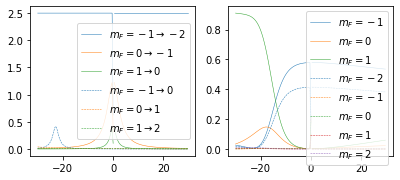

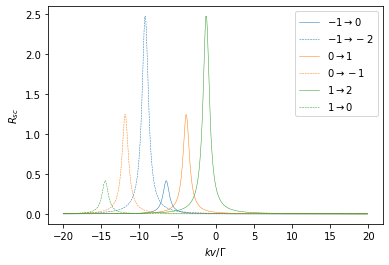

In [9]:
# Along the line v = delta - alpha x, we
v_path = det - alpha*x

trap.generate_force_profile([x, np.zeros(x.shape), np.zeros(x.shape)],
                            [v_path, np.zeros(x.shape), np.zeros(x.shape)],
                            name='res_path')

# Plot up the  the scattering rates and equilbrium populations vs. x, adjusting
# for the switch of basis at x=0
fig, ax = plt.subplots(1,2,figsize=(6.5,2.75))
for ii in range(3):
    ax[0].plot(x[x<0], trap.profile['res_path'].Rijl['g->e'][x<0, 0, ii, ii],
               color='C{0:d}'.format(ii), linewidth=0.5,
               label='$m_F= {0:d}\\rightarrow {1:d}$'.format(ii-1,ii-2))
    ax[0].plot(x[x>0], trap.profile['res_path'].Rijl['g->e'][x>0, 0, -1-ii, -1-ii],
               color='C{0:d}'.format(ii), linewidth=0.5)

for ii in range(3):
    ax[0].plot(x[x<0], trap.profile['res_path'].Rijl['g->e'][x<0, 1, ii, ii+2],
               '--', color='C{0:d}'.format(ii),
               linewidth=0.5,
               label='$m_F= {0:d}\\rightarrow {1:d}$'.format(ii-1,ii))
    ax[0].plot(x[x>0], trap.profile['res_path'].Rijl['g->e'][x>0, 1, -1-ii, -1-ii-2],
               '--', color='C{0:d}'.format(ii), linewidth=0.5)
ax[0].legend()

for ii in range(3):
    ax[1].plot(x[x<0], trap.profile['res_path'].Neq[x<0, ii], '-',
               color='C{0:d}'.format(ii), linewidth=0.5)
    ax[1].plot(x[x>0], trap.profile['res_path'].Neq[x>0, ham.ns[0]-ii-1], '-',
               color='C{0:d}'.format(ii),
               linewidth=0.5, label='$m_F= {0:d}$'.format(ii-1))
for ii in range(5):
    ax[1].plot(x[x<0], trap.profile['res_path'].Neq[x<0, ham.ns[0]+ii],'--',
               color='C{0:d}'.format(ii),
               linewidth=0.5)
    ax[1].plot(x[x>0], trap.profile['res_path'].Neq[x>0, -1-ii],'--',
               color='C{0:d}'.format(ii),
               linewidth=0.5, label='$m_F''= {0:d}$'.format(ii-2))

ax[1].legend()

# Plot up the scattering rates vs. velocity at a given field:
Bmag = alpha*15
delta = -4
v = np.arange(-20,20,0.1)
fijq = np.array([10, 30, 60])

plt.figure()
for ii in range(3):
    plt.plot(v, beta/2*(fijq[ii]/60)/\
             (1+4*(delta + v - ((3/4-1/2)*(ii-1)*Bmag - 3/4*Bmag))**2),
         '-', color='C{0:d}'.format(ii), linewidth=0.5,
         label='${0:d}\\rightarrow{1:d}$'.format(ii-1,ii))
    plt.plot(v, beta/2*(fijq[-1-ii]/60)/\
             (1+4*(delta - v - ((3/4-1/2)*(ii-1)*Bmag + 3/4*Bmag))**2),
         '--', color='C{0:d}'.format(ii), linewidth=0.5,
         label='${0:d}\\rightarrow{1:d}$'.format(ii-1,ii-2))
plt.legend()
plt.xlabel('$kv/\Gamma$')
plt.ylabel('$R_{sc}$')